# Detecting COVID-19 & Viral Pneumonia in X-Ray Images

Dataset from: https://www.kaggle.com/tawsifurrahman/covid19-radiography-database?

Code: https://keisen.github.io/tf-keras-vis-docs/examples/attentions.html

Other COVID-19 X-Rays @ https://www.kaggle.com/nabeelsajid917/covid-19-x-ray-10000-images?

# In the past section:

1) Intro Covid-19

2) Practice Object Detection - Lung Area in the X-Ray Image
    -- Microsoft COCO - Computer Vision project on a lot of annotated images for 80 classes

# Today's Section:

1) Data preparation of Classification data(80% time and efforts)

2) Move on to Google Colab (GPU/TPU) to do multi-class (4 classes)



# Import Libraries

In [2]:
import numpy as np
import pandas as pd
from random import shuffle
import random
import os
import matplotlib.pyplot as plt


from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import vis # custom module for visualisation

import torch, gc
gc.collect()
torch.cuda.empty_cache()

2024-03-16 14:20:35.787522: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-16 14:20:35.981539: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-16 14:20:35.981565: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-16 14:20:36.011437: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-16 14:20:36.077511: I tensorflow/core/platform/cpu_feature_guar

In [3]:
import tensorflow as tf
import tensorflow.image as tfi
from keras.preprocessing.image import load_img, img_to_array

In [4]:
def load_image(image, SIZE):
    image = tf.cast(tfi.resize(img_to_array(load_img(image)), (SIZE, SIZE)), tf.float32)/255.
    return image

def load_images(paths, SIZE, trim=None, channels=3):
  
    if trim is not None:
        paths = paths[:trim]
        images = np.zeros(shape=(len(paths), SIZE, SIZE, channels))

    if channels==3:
        for i, path in enumerate(paths):
            img = load_image(path, SIZE)
            images[i] = img
    elif channels==1:
        for i, path in enumerate(paths):
            img = load_image(path, SIZE)
            images[i] = img[:,:,:1]
    return images
def show_image(image, title=None, cmap=None, alpha=1.0):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None: plt.title(title)
    plt.axis('off')
def show_mask(image, mask, cmap='jet', alpha=0.2):
    show_image(image)
    show_image(tf.squeeze(mask), cmap=cmap, alpha=alpha)

# Define Constants

In [5]:
root_path = '../Week7/COVID-19_Radiography_Dataset/'
l1 = os.listdir(root_path)
print(l1)

IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256

IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


In [6]:
labels = []
image_paths = []
mask_paths = []

for i in l1:
    #print(i)
    l2 = os.listdir(root_path+i)
    
    for j in l2:
        #print("i is", i)
        l3 = os.listdir(root_path+i+'/'+j)
        for k in l3:
            if (j=='images') and (".ipynb_checkpoints" != k):
                # img = Image.open(root_path+i+'/'+j+'/'+k)
                image_paths.append(root_path+i+'/'+j+'/'+k) 
                labels.append(i)
            elif (j=='masks') and (".ipynb_checkpoints" != k):
                mask_paths.append(root_path+i+'/'+j+'/'+k) 

In [7]:
uniq_cnt = np.unique(labels, return_counts= True) 
uniq_cnt

(array(['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia'], dtype='<U15'),
 array([ 3616,  6012, 10192,  1345]))

In [8]:
images = load_images(image_paths, SIZE=256, trim=200)
masks = load_images(mask_paths, SIZE=256, trim=200, channels=1)

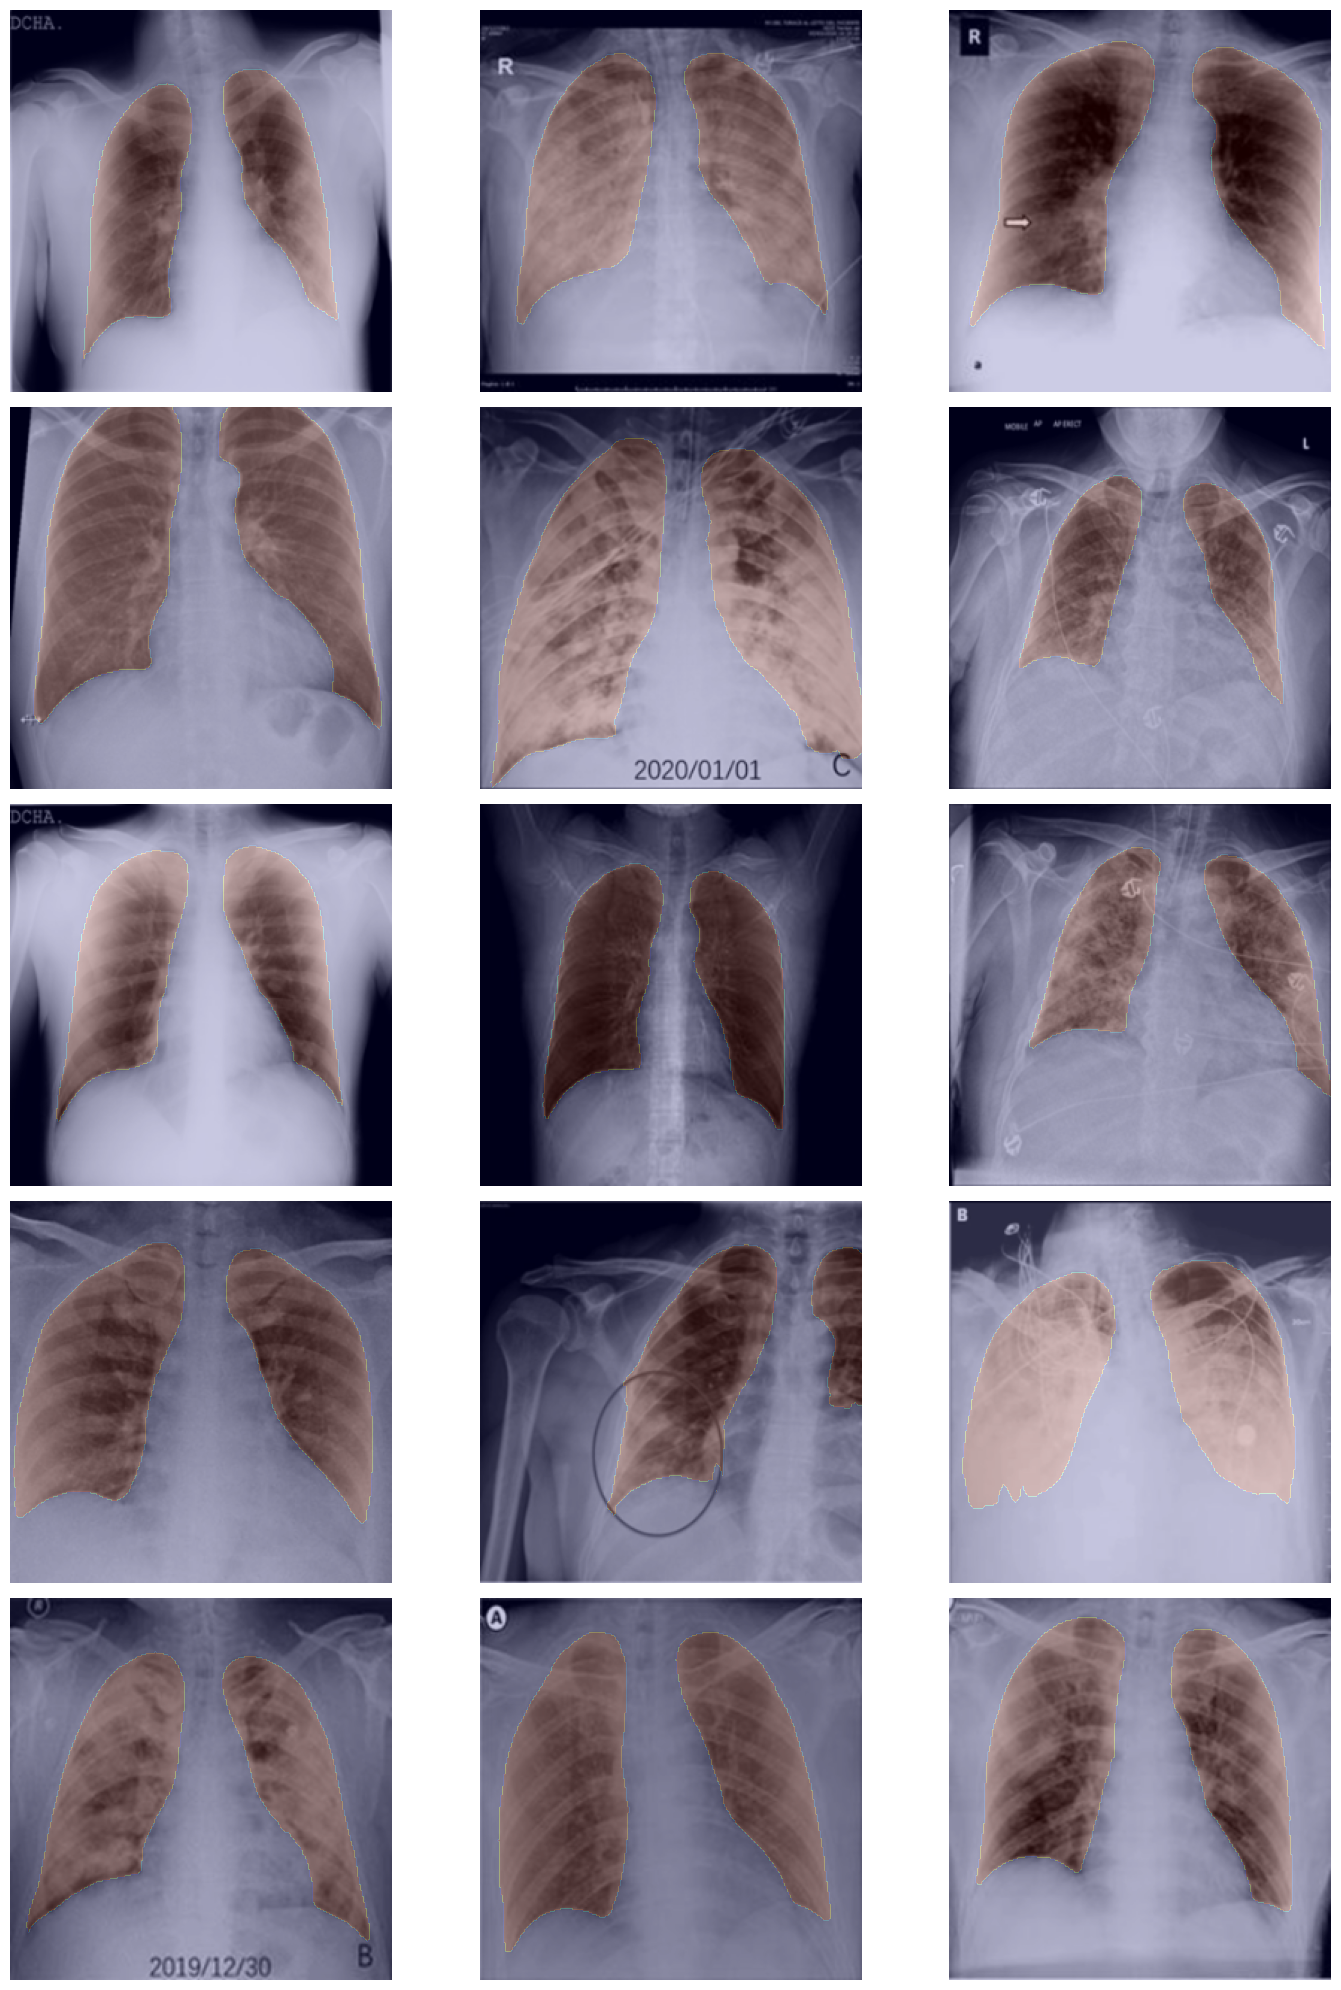

In [9]:
plt.figure(figsize=(15,20))
for i in range(1,16):
    plt.subplot(5,3,i)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id])
plt.tight_layout()
plt.show()

In [10]:
import random

In [11]:
labels = []
file_path = []

for i in l1:
    #print(i)        
    l2 = os.listdir(root_path+i+"/images")
    
    if i == 'Viral Pneumonia':
        l3 = l2
    else:
        random.seed(1234)
        l3 = random.sample(l2, int(len(l2)*0.5))
        
    for j in l3:            
        #j = j.replace(" ", "_")
        os.system(f"cp '{root_path}{i}/images/{j}' ../Week8/train")     
        file_path.append(f"train/{j}")
        labels.append(i)

In [12]:
np.unique(labels, return_counts = True)

(array(['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia'], dtype='<U15'),
 array([1808, 3006, 5096, 1345]))

In [13]:
len(file_path)

11255

In [14]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    

    if dropout_prob > 0:         
        conv = Dropout(dropout_prob)(conv)

    if max_pooling:
        next_layer = MaxPooling2D()(conv)
        
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    

    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    
    return conv

def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=1):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)

    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], n_filters * 2)
    cblock3 = conv_block(cblock2[0], n_filters * 4)
    cblock4 = conv_block(cblock3[0], n_filters * 8, dropout_prob=0.3)

    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 

    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters * 8)

    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)


    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same', activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

img_height = 256
img_width = 256
num_channels = 3



# Prepare Training Data

In [15]:
file_path

['train/COVID-612.png',
 'train/COVID-2623.png',
 'train/COVID-1429.png',
 'train/COVID-1025.png',
 'train/COVID-1332.png',
 'train/COVID-719.png',
 'train/COVID-3144.png',
 'train/COVID-1127.png',
 'train/COVID-3474.png',
 'train/COVID-3553.png',
 'train/COVID-1307.png',
 'train/COVID-1361.png',
 'train/COVID-57.png',
 'train/COVID-2305.png',
 'train/COVID-1871.png',
 'train/COVID-1062.png',
 'train/COVID-1111.png',
 'train/COVID-651.png',
 'train/COVID-1056.png',
 'train/COVID-2274.png',
 'train/COVID-3389.png',
 'train/COVID-3296.png',
 'train/COVID-2784.png',
 'train/COVID-3269.png',
 'train/COVID-2707.png',
 'train/COVID-1546.png',
 'train/COVID-1334.png',
 'train/COVID-1673.png',
 'train/COVID-374.png',
 'train/COVID-142.png',
 'train/COVID-860.png',
 'train/COVID-1051.png',
 'train/COVID-2853.png',
 'train/COVID-2793.png',
 'train/COVID-192.png',
 'train/COVID-1236.png',
 'train/COVID-3459.png',
 'train/COVID-2994.png',
 'train/COVID-2716.png',
 'train/COVID-1250.png',
 'train/C

In [16]:
df = pd.DataFrame({
    'filename': file_path,
    'category': labels
})

In [17]:
df.head()

filename category
0   train/COVID-612.png    COVID
1  train/COVID-2623.png    COVID
2  train/COVID-1429.png    COVID
3  train/COVID-1025.png    COVID
4  train/COVID-1332.png    COVID

In [18]:
df.tail()

filename         category
11250  train/Viral Pneumonia-995.png  Viral Pneumonia
11251  train/Viral Pneumonia-996.png  Viral Pneumonia
11252  train/Viral Pneumonia-997.png  Viral Pneumonia
11253  train/Viral Pneumonia-998.png  Viral Pneumonia
11254  train/Viral Pneumonia-999.png  Viral Pneumonia

In [19]:
df["cls"] = np.where(df.category == "Normal", 0, np.where(df.category == "COVID", 1, np.where(df.category == "Viral_Pneumonia", 2, 3))) 

In [20]:
df.category.value_counts()

category
Normal             5096
Lung_Opacity       3006
COVID              1808
Viral Pneumonia    1345
Name: count, dtype: int64

# Compare Frequencies 

<Axes: xlabel='category'>

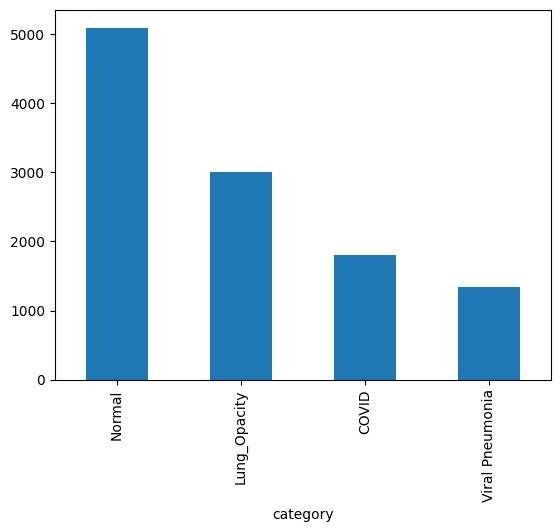

In [21]:
'''
0 Represents Normal 
1 Represents COVID
2 Represents Viral_Pneumonia 
3 Represents Lung_Opacity
'''
df['category'].value_counts().plot.bar()

# Load Sample Image

In [22]:
import pickle

In [23]:
pickle.dump(df, open("train_df.pkl", "wb"))

Normal-9869.png


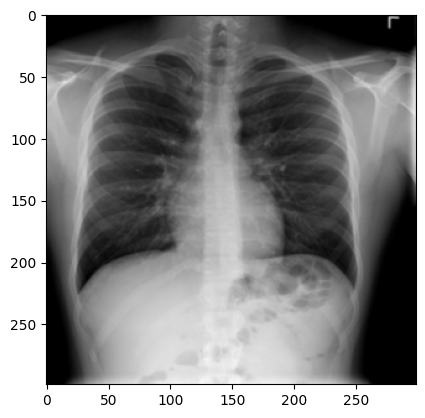

In [24]:
sample = random.choice(os.listdir("./train/"))
image = load_img("./train/" + sample)

print(sample)
plt.imshow(image)

# Design Deep Learning Model

1. **Input Layer**: This represents our input image data. It will reshape the image into a single dimensional array. For example, if your image is 64x64, it will convert to (4096,1) array (64x64 = 4096).


2. **Conv Layer**: This layer will extract features from image.


3. **Pooling Layer**: This layer will reduce the spatial volume of input image after convolution.


4. **Fully Connected Layer**: This will connect the network from a layer to another layer


5. **Output Layer**: This is the predicted values layer.

In [25]:
# Data Viz
import matplotlib.pyplot as plt
from tqdm import tqdm 
# Model 
from keras.models import Model
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import UpSampling2D
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Add
from keras.layers import concatenate
from keras.layers import Multiply
from keras.layers import Input


from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Multiply
from tensorflow.keras.layers import Add

from keras.preprocessing.image import load_img, img_to_array

# Metrics
from keras.metrics import MeanIoU

# Callbacks
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
from tf_explain.core.grad_cam import GradCAM


In [26]:
BATCH_SIZE = 32
SPE = len(images)//BATCH_SIZE

In [28]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(unet_model((img_height, img_width, num_channels)))
                  #,n_filters=32, n_classes=1))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',MeanIoU(2)])
#model.fit(
 #   images, masks,
  #  validation_split=0.1,
   # epochs=10, # This is more than sufficient
    #steps_per_epoch=SPE)

model.add(Conv2D(64, (7, 7), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax', name='predictions')) 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 256, 256, 1)       8639745   
                                                                 
 conv2d_20 (Conv2D)          (None, 250, 250, 64)      3200      
                                                                 
 batch_normalization (Batch  (None, 250, 250, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 125, 125, 64)      0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 125, 125, 64)      0         
                                                                 
 conv2d_21 (Conv2D)          (None, 121, 121, 128)     2

# Callbacks

## Early Stop

To prevent overfitting, we will stop the learning after 10 epochs and if the val_loss value has not decreased

In [29]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)

In [30]:
pickle.dump(df, open("train_df.pkl", "wb"))

# Learning Rate Reduction

We will reduce the learning rate when then accuracy does not increase for 2 steps

In [31]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', 
                                            patience = 2, 
                                            verbose = 1, 
                                            factor = 0.5, 
                                            min_lr = 0.00001)

callbacks = [earlystop, learning_rate_reduction]

# Shuffle Data

In [32]:
pickle.dump(df, open("train_df.pkl", "wb"))

In [33]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=1234)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [34]:
train_df['category'].shape

(9004,)

In [35]:
df

filename         category  cls
0                train/COVID-612.png            COVID    1
1               train/COVID-2623.png            COVID    1
2               train/COVID-1429.png            COVID    1
3               train/COVID-1025.png            COVID    1
4               train/COVID-1332.png            COVID    1
...                              ...              ...  ...
11250  train/Viral Pneumonia-995.png  Viral Pneumonia    3
11251  train/Viral Pneumonia-996.png  Viral Pneumonia    3
11252  train/Viral Pneumonia-997.png  Viral Pneumonia    3
11253  train/Viral Pneumonia-998.png  Viral Pneumonia    3
11254  train/Viral Pneumonia-999.png  Viral Pneumonia    3

[11255 rows x 3 columns]

In [36]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 48

# Training Generator

In [37]:
train_datagen = ImageDataGenerator (
    
    rotation_range = 15,
    rescale = 1./255,
    
    shear_range = 0.1,
    zoom_range = 0.2,
    
    horizontal_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

train_generator = train_datagen.flow_from_dataframe (
    
    train_df, 
    './', 
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 9004 validated image filenames belonging to 4 classes.


# Validation Generator

In [38]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe (
    
    validate_df, 
    './', 
    x_col ='filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 2251 validated image filenames belonging to 4 classes.


# Visualize Generator 

In [39]:
example_df = train_df.sample(n=1).reset_index(drop=True)

example_generator = train_datagen.flow_from_dataframe (
    
    example_df, 
    './', 
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical'
)

Found 1 validated image filenames belonging to 1 classes.


                        filename         category  cls
0  train/Viral Pneumonia-563.png  Viral Pneumonia    3


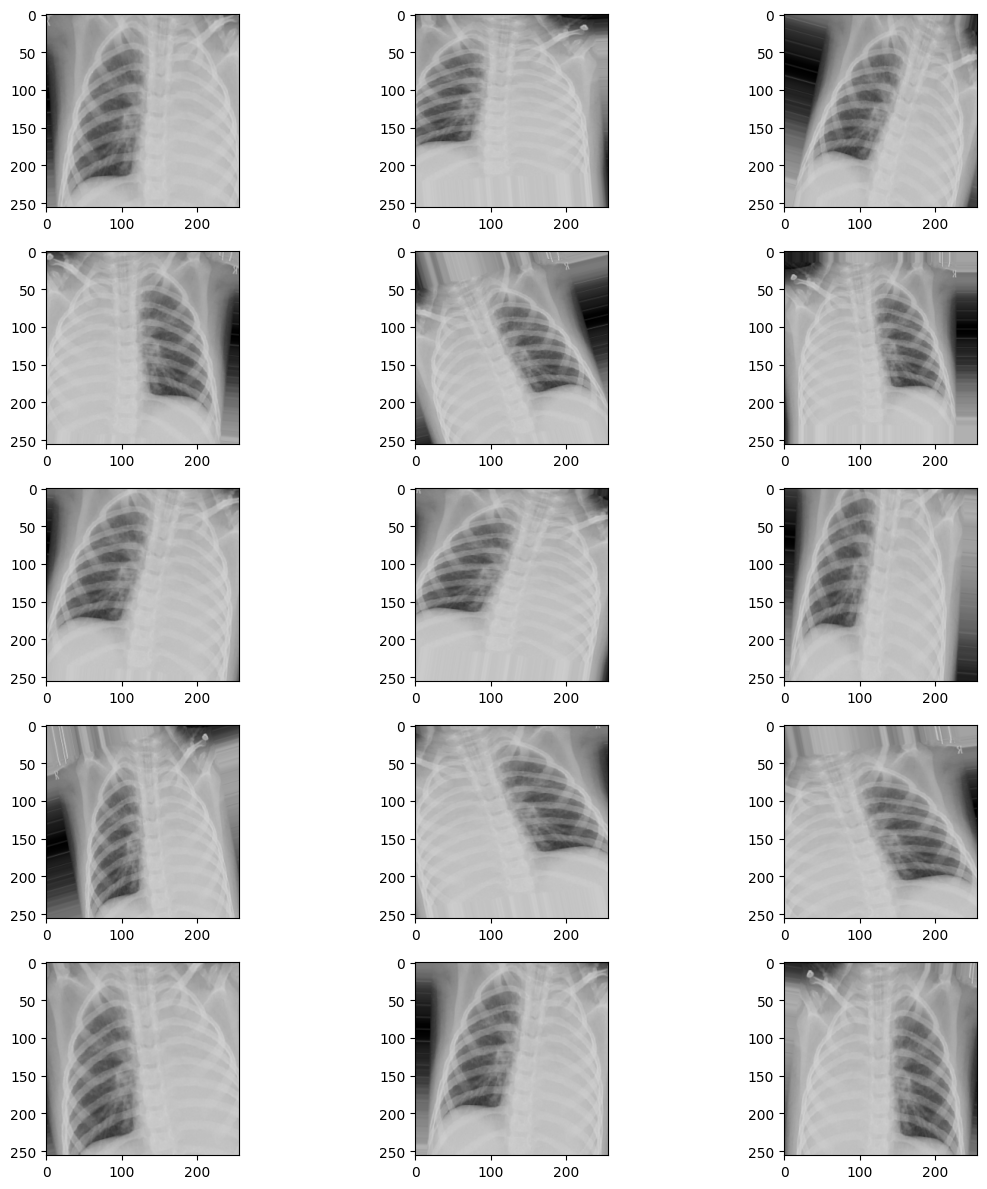

In [40]:
print(example_df)

plt.figure(figsize=(12, 12))

for i in range(0, 15):
    
    plt.subplot(5, 3, i+1)
    
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
        
plt.tight_layout()
plt.show()

In [ ]:
# from numba import cuda
# device = cuda.get_current_device()
# device.reset()

import taichi as ti

ti.init(arch=ti.gpu)

n = 320
pixels = ti.field(dtype=float, shape=(n * 2, n))


@ti.func
def complex_sqr(z):
    return ti.Vector([z[0]**2 - z[1]**2, z[1] * z[0] * 2])


@ti.kernel
def paint(t: float):
    for i, j in pixels:  # Parallelized over all pixels
        c = ti.Vector([-0., ti.cos(t) * 0.2])
        z = ti.Vector([i / n - 1, j / n - 0.5]) * 2
        iterations = 0
        while z.norm() < 20 and iterations < 50:
            z = complex_sqr(z) + c
            iterations += 1
        pixels[i, j] = 1 - iterations * 0.02


gui = ti.GUI("Julia Set", res=(n * 2, n))

for i in range(1000000):
    paint(i * 0.03)
    gui.set_image(pixels)
    gui.show()

In [42]:
epochs = 15

history = model.fit(    
    train_generator, 
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = total_validate//batch_size,
    steps_per_epoch = total_train//batch_size,
    callbacks = callbacks
)

Epoch 1/15
187/187 [==============================] - 1284s 7s/step - loss: 1.7406 - accuracy: 0.3332 - val_loss: 4.6369 - val_accuracy: 0.4538 - lr: 0.0010
Epoch 2/15
187/187 [==============================] - 1286s 7s/step - loss: 1.4721 - accuracy: 0.3591 - val_loss: 17.0204 - val_accuracy: 0.1608 - lr: 0.0010
Epoch 3/15
187/187 [==============================] - ETA: 0s - loss: 1.3612 - accuracy: 0.3876
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
187/187 [==============================] - 1300s 7s/step - loss: 1.3612 - accuracy: 0.3876 - val_loss: 46.1698 - val_accuracy: 0.2654 - lr: 0.0010
Epoch 4/15
187/187 [==============================] - 1313s 7s/step - loss: 1.3188 - accuracy: 0.4166 - val_loss: 125.0532 - val_accuracy: 0.2654 - lr: 5.0000e-04
Epoch 5/15
187/187 [==============================] - ETA: 0s - loss: 1.3009 - accuracy: 0.4265
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
187/187 [======================

In [ ]:
model.save_weights("COVID-Model-{}-{}-{}-{}.h5".format(IMAGE_WIDTH, 3, batch_size, epochs))

# Visualize Training Performance 

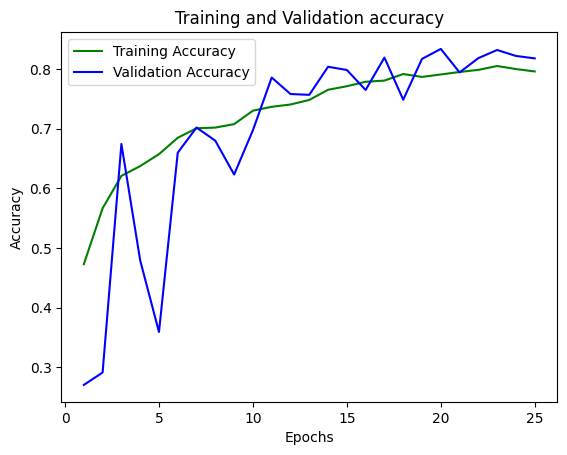

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
numEpochs = range(1,  epochs + 1)
plt.plot(numEpochs, accuracy, 'g', label='Training Accuracy')
plt.plot(numEpochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

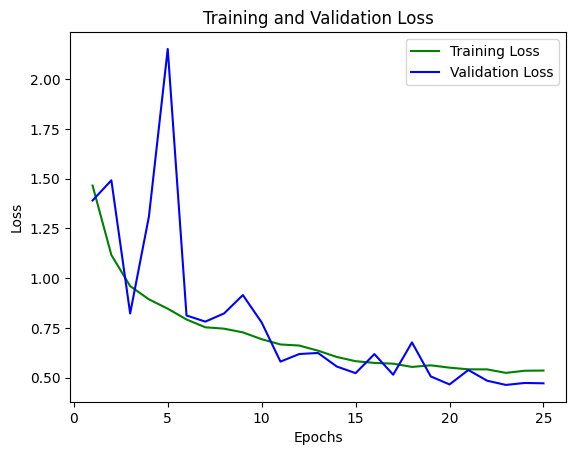

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
numEpochs = range(1,  epochs + 1)
plt.plot(numEpochs, loss, 'g', label='Training Loss')
plt.plot(numEpochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Prepare Testing Data

In [ ]:
test_labels = []
test_files = []

for i in l1:
    #print(i)
    l2 = os.listdir(root_path+i+"/images")
    random.seed(1234)
    l3 = random.sample(l2, 100)  
    for j in l3:            
        j_ = j.replace(" ", "_")
        os.system(f"cp {root_path}'{i}'/images/'{j}' ../Week8/test/")     
        test_files.append(f"train/{j_}")
        test_labels.append(i)

In [ ]:
len(test_files)

400

In [ ]:
test_filenames = os.listdir('./test')
print(len(test_filenames))

test_df = pd.DataFrame({
    'filename': ["test/"+i for i in test_filenames]
})

nb_samples = test_df.shape[0]

400


In [ ]:
test_df.head()

filename
0  test/COVID-1019.png
1  test/COVID-1025.png
2  test/COVID-1051.png
3  test/COVID-1056.png
4  test/COVID-1062.png

# Create Testing Generator

In [ ]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_dataframe(
    
    test_df, 
    './', 
    x_col = 'filename',
    y_col = None,
    class_mode = None,
    target_size = IMAGE_SIZE,
    batch_size = batch_size,
    shuffle = False
)

Found 400 validated image filenames.


# Form Predictions

In [ ]:
predict = model.predict(test_generator, steps = np.ceil(nb_samples/batch_size))

9/9 [==============================] - 4s 469ms/step


## Pick the category that has the highest probability 

In [ ]:
test_df['category'] = np.argmax(predict, axis = 1)

In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

<Axes: xlabel='category'>

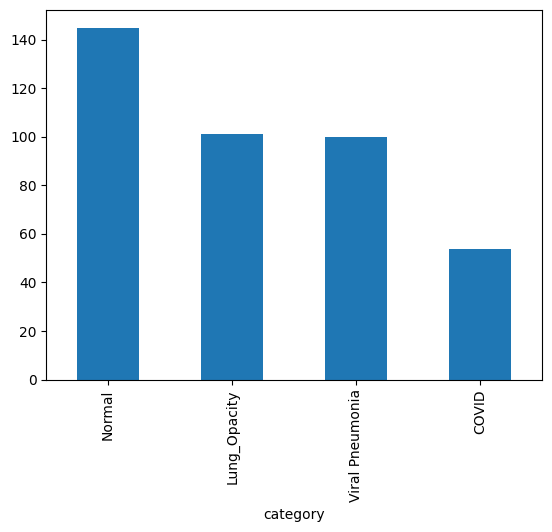

In [ ]:
test_df['category'].value_counts().plot.bar()

# Predicted result with images

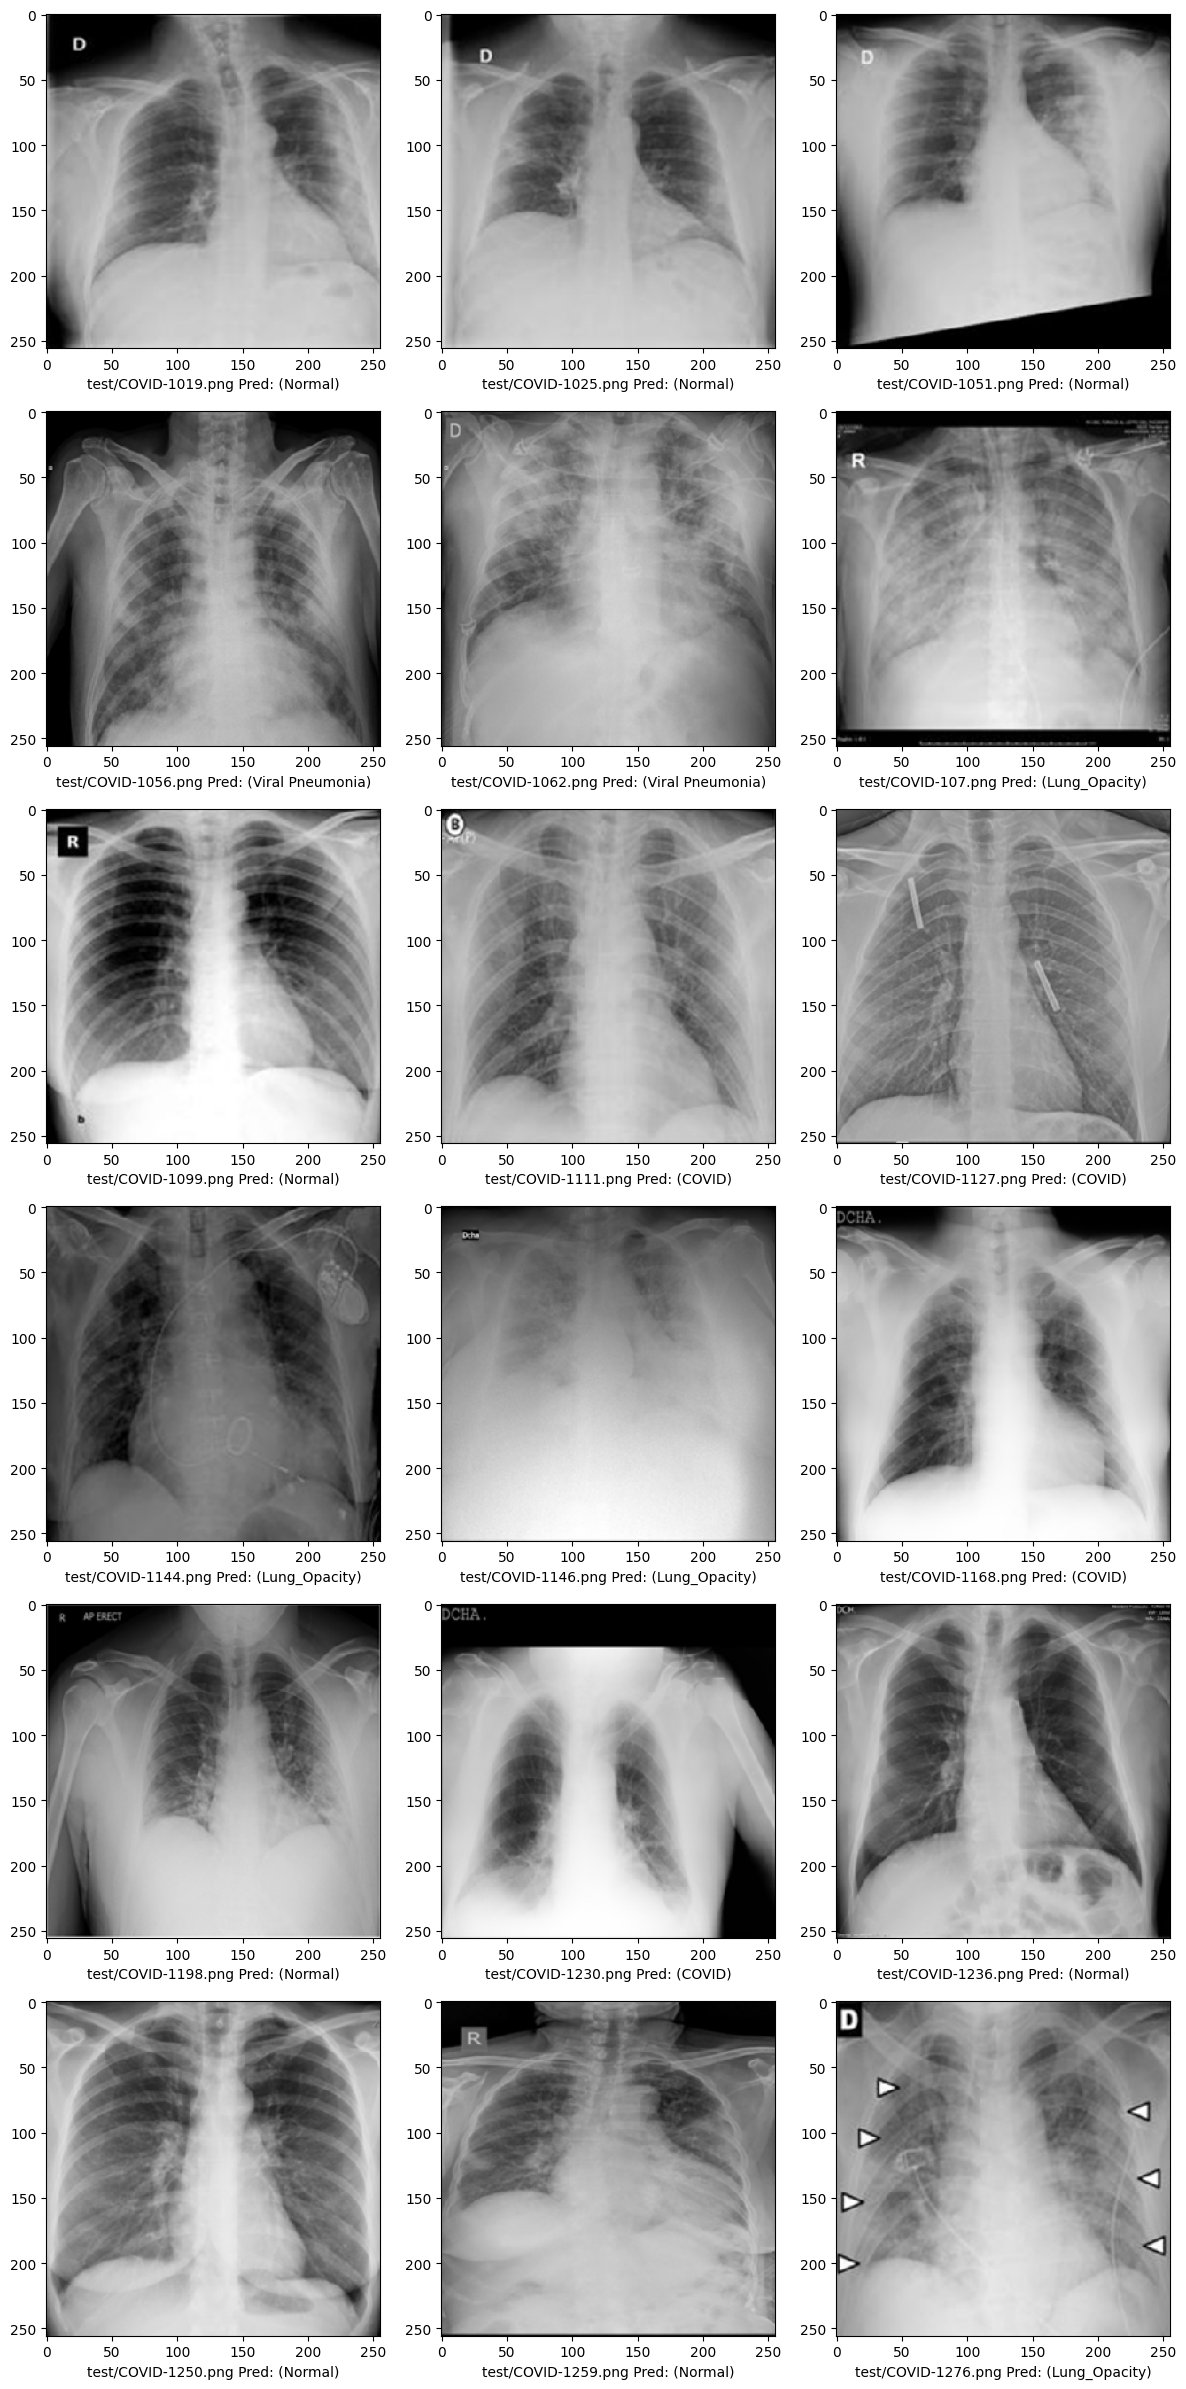

In [ ]:
sample_test = test_df.head(18)
sample_test.head()

plt.figure(figsize=(12, 24))

for index, row in sample_test.iterrows():
    
    filename = row['filename']
    category = row['category']
    
    img = load_img(filename, target_size=IMAGE_SIZE)
    
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + ' Pred: (' + "{}".format(category) + ')' )
    
plt.tight_layout()
plt.show()

# Calculate Model Accuracy

In [ ]:
sample_test.head()

filename         category
0  test/COVID-1019.png           Normal
1  test/COVID-1025.png           Normal
2  test/COVID-1051.png           Normal
3  test/COVID-1056.png  Viral Pneumonia
4  test/COVID-1062.png  Viral Pneumonia

In [ ]:
sample_test = test_df
correctPredictions = 0

correctNormalPred = 0
correctCovidPred = 0
correctPneuPred = 0
correctOpaPred = 0

totalNormalPred = 0
totalCovidPred = 0
totalPneuPred = 0
totalOpaPred =0

for index, row in sample_test.iterrows():
    
    filename = row['filename']
    prediction = row['category']
    
    img = load_img(filename, target_size=IMAGE_SIZE)
    
    if 'Normal' in filename:
        
        if prediction == 'Normal':
            correctPredictions += 1
            correctNormalPred += 1
            
        totalNormalPred += 1
    
    if 'COVID' in filename:
        
        if prediction == "COVID": 
            correctPredictions += 1
            correctCovidPred += 1
            
        totalCovidPred += 1
    
    if 'Viral Pneumonia' in filename:
        
        if prediction == "Viral Pneumonia": 
            correctPredictions += 1
            correctPneuPred += 1
            
        totalPneuPred += 1
            
    if 'Lung_Opacity' in filename:
        
        if prediction == 'Lung_Opacity': 
            correctPredictions += 1
            correctOpaPred += 1
            
        totalOpaPred += 1
    

In [ ]:
print('Model Accuracy:', "{:.2%}".format(correctPredictions / test_df.shape[0]))
print('Correct Predictions:', correctPredictions, 'Total Predictions:', test_df.shape[0])

print('\nNormal Predictions:', correctNormalPred, 'Accuracy', "{:.2%}".format(correctNormalPred /  totalNormalPred))
print('COVID Predictions:', correctCovidPred, 'Accuracy', "{:.2%}".format(correctCovidPred /  totalCovidPred))
print('Viral_Pneumonia Predictions:', correctPneuPred, 'Accuracy', "{:.2%}".format(correctPneuPred / totalPneuPred))
print('Lung_Opacity Predictions:', correctOpaPred, 'Accuracy', "{:.2%}".format(correctOpaPred / totalOpaPred))

Model Accuracy: 78.75%
Correct Predictions: 315 Total Predictions: 400

Normal Predictions: 95 Accuracy 95.00%
COVID Predictions: 47 Accuracy 47.00%
Viral_Pneumonia Predictions: 95 Accuracy 95.00%
Lung_Opacity Predictions: 78 Accuracy 78.00%


In [ ]:
test_df["observed"] = [i.split("-")[0].split("/")[1] for i in test_df.filename]

In [ ]:
test_df.head()

filename         category observed
0  test/COVID-1019.png           Normal    COVID
1  test/COVID-1025.png           Normal    COVID
2  test/COVID-1051.png           Normal    COVID
3  test/COVID-1056.png  Viral Pneumonia    COVID
4  test/COVID-1062.png  Viral Pneumonia    COVID

In [ ]:
print(classification_report(test_df.category, test_df.observed))

                 precision    recall  f1-score   support

          COVID       0.47      0.87      0.61        54
   Lung_Opacity       0.78      0.77      0.78       101
         Normal       0.95      0.66      0.78       145
Viral Pneumonia       0.95      0.95      0.95       100

       accuracy                           0.79       400
      macro avg       0.79      0.81      0.78       400
   weighted avg       0.84      0.79      0.80       400



In [ ]:
confusion_matrix(test_df.category, test_df.observed)

array([[47,  6,  1,  0],
       [19, 78,  4,  0],
       [29, 16, 95,  5],
       [ 5,  0,  0, 95]])

# Visualizing CNN Model

It is crucial that we visualize what our model is doing – and on what basis it is making its predictions. Saliency maps form a visualization of the pixels in the image that contribute the most to predictions by the model. 

In [ ]:
from keras.models import load_model
model.load_weights('COVID-Model-256-3-48-25.h5')

In [ ]:
#pip install tensorflow[and-cuda] -U

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
image_titles = ['Normal', 'Lung_Opacity', 'COVID', 'Viral_Pneumonia',]

In [ ]:
img1 = load_img('../Week7/COVID-19_Radiography_Dataset/Normal/images/Normal-1000.png', target_size=(256, 256))
img2 = load_img('../Week7/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-1000.png', target_size=(256, 256))
img3 = load_img('../Week7/COVID-19_Radiography_Dataset/COVID/images/COVID-1000.png', target_size=(256, 256))
img4 = load_img('../Week7/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-1000.png', target_size=(256, 256))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3), np.array(img4)])

In [ ]:
X = preprocess_input(images)

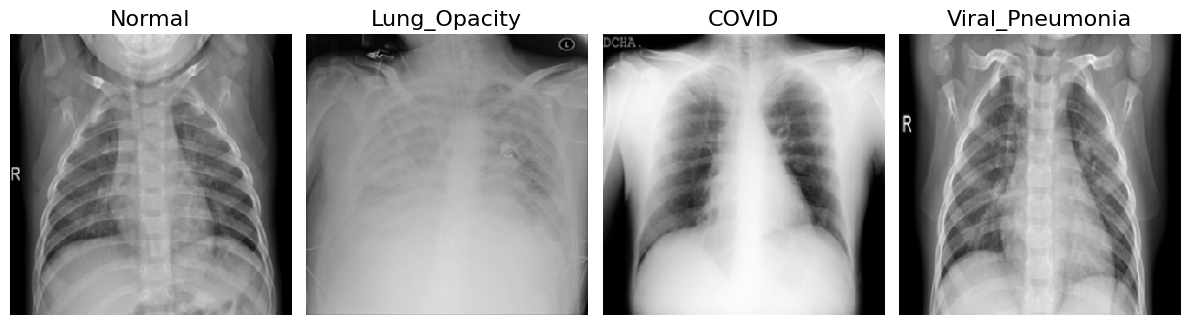

In [ ]:
# Rendering
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from matplotlib import cm

try:
    from tf_keras_vis.gradcam import Gradcam
except:
    !pip install tf-keras-vis
    from tf_keras_vis.gradcam import Gradcam

  Using cached imageio-2.34.0-py3-none-any.whl.metadata (4.9 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 1.3 MB/s eta 0:00:0000:01
Using cached imageio-2.34.0-py3-none-any.whl (313 kB)


In [ ]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.utils.scores import CategoricalScore

replace2linear = ReplaceToLinear()

# Create ScoreCAM object
scorecam = Scorecam(model, model_modifier=replace2linear)

In [ ]:
score = CategoricalScore([0, 1, 2, 3])

In [ ]:
# Generate heatmap with Faster-ScoreCAM
cam = scorecam(score,
               X,
               penultimate_layer=-1,
               max_N=10)

2/2 [==============================] - 1s 289ms/step


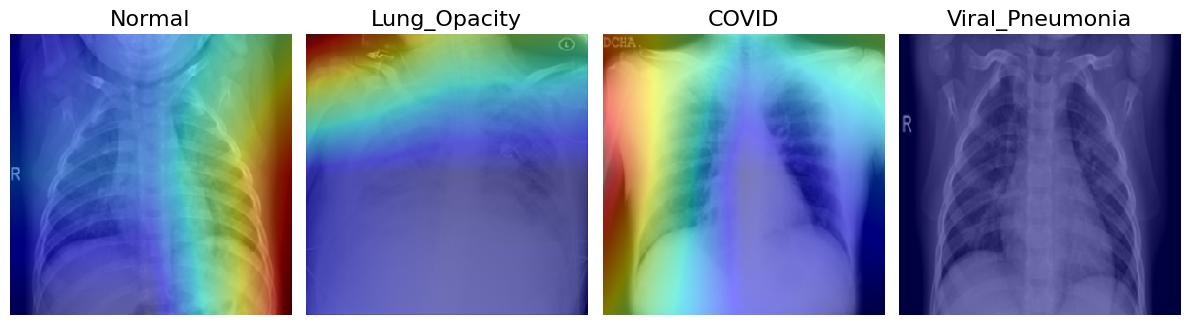

In [ ]:
# Render
f, ax = plt.subplots(nrows=1, ncols=4,figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()